<a href="https://colab.research.google.com/github/kumiori/mec647/blob/main/test_ayoub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import site
import sys


try : 
    from google.colab import files
except:
    pass
    
try:
    from fenics import *; from mshr import *
except ImportError as e:
    !apt-get install software-properties-common
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y fenics    
    site.addsitedir('/usr/lib/petsc/lib/python3/dist-packages')  # Always appends to end

    from fenics import *; from mshr import *
    from ufl import replace

!fenics-version

2019.2.0.dev0


In [34]:
import matplotlib.pyplot as plt
import numpy as np
import math  
from IPython.display import clear_output, display, update_display; import time; 
# import dolfin.common.plotting as fenicsplot 
import time
%matplotlib inline
plt.rcParams['image.cmap'] = 'viridis'

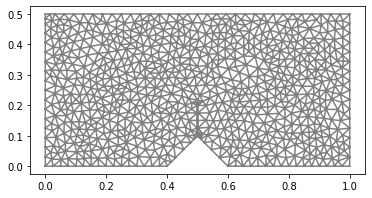

In [78]:
L = 1.; H = .5
a=.1 ; Hcrack=.1 ;Lcrack=.002

P1= Point(L/2-a,0.)
P2= Point(L/2,a)
P3= Point((L/2+a),0.)

C1=Point((L/2-Lcrack),a)
C2=Point((L/2+Lcrack),a+Hcrack)
Crack=Rectangle(C1,C2)

#x=np.array([L/2-a/2,L/2,L/2+a/2,L/2-a/2])
#y=np.array([0,a/2.5,0,0])
#plt.plot(x,y)

notchVertices= [P4,P2,P1,P3,P2,P4]
notch = Polygon(notchVertices)
geom= Rectangle(Point(0., 0.), Point(L, H))
G=geom-notch-Crack

cell_size = 0.04
nel = int(L/cell_size)

mesh = generate_mesh(G, nel)
plot(mesh)


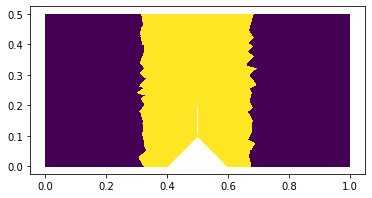

In [80]:
ndim = mesh.topology().dim()

cell_mrk=MeshFunction('bool',mesh,ndim)
cell_mrk.set_all(False)
D=(L/2-a)/5

for cell in cells(mesh):
  if L/2-a-D<cell.midpoint()[0]<L/2+a+D:
    cell_mrk[cell]= True

plot(cell_mrk)

meshFine = refine(mesh,cell_mrk)
#mesh= refine(mesh,cell_mrk)